In [1]:
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
from    scipy.stats             import  norm
from    scipy.stats             import  gaussian_kde

np.random.seed(5)
plt.style.use('ggplot')

In [2]:
r           = 0.05
S0          = 100
sigma       = 0.3
T           = 1
delta       = 1/10 # 10 business days, ie. 2 weeks
dt          = 1/100 # 1 business day

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M           = 3
tref        = 0.5
ind_tref    = int(tref/dt)

K           = 95.

def beta(t):
    return np.exp(-r*t)

In [3]:
def gen_S(S0, M, N):
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

S_paths = gen_S(S0, M, N)

In [4]:
def gen_mtm_put(S_paths, time_grid):
    M   = S_paths.shape[0]
    N   = S_paths.shape[1]-1
    mtm = np.zeros((M, N+1))
    for i in range(N+1):
        d1          = (np.log(S_paths[:, i]/K) + (r + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm[:, i]   = K*beta(T-time_grid[i])*norm.cdf(-d2) - S_paths[:, i]*norm.cdf(-d1)
        
    return mtm

mtm_paths       = gen_mtm_put(S_paths, time_grid)
mtm_diff_paths  = mtm_paths[:, int(delta/dt):] - mtm_paths[:, :-int(delta/dt)]

## <span id="section-1" style="color:#00B8DE"> I - Nested Monte-Carlo  </span>

In [5]:
M_inner = 2000
ind_tdelta = int((tref+delta)/dt)
S_paths_nested = np.zeros((M, M_inner, ind_tdelta-ind_tref+1))
mtm_nested_paths = np.zeros((M, M_inner, ind_tdelta-ind_tref+1))
mtm_diff_val = np.zeros((M, M_inner))
for m in range(M):
    S_paths_nested[m, :, :] = gen_S(S_paths[m, ind_tref], M_inner, ind_tdelta-ind_tref)
    mtm_nested_paths[m, :, 1:] = gen_mtm_put(S_paths_nested[m, :, 1:], time_grid[ind_tref+1:ind_tdelta+1])
    mtm_nested_paths[m, :, 0] = mtm_paths[m, ind_tref]
    mtm_diff_val[m, :] = mtm_nested_paths[m, :, -1] - mtm_nested_paths[m, :, 0]

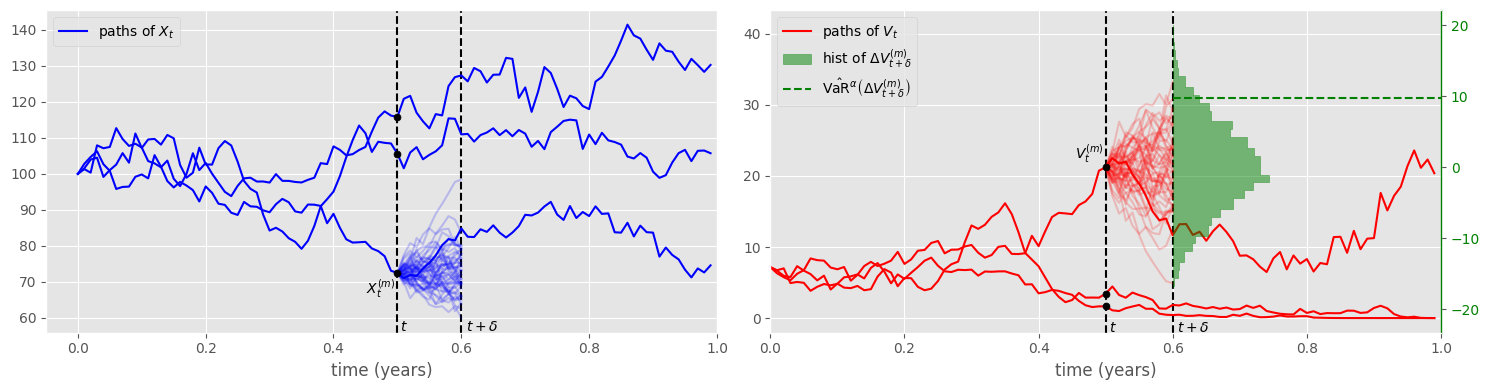

In [ ]:
M_inner_disp = 50
inner_disp = np.random.choice(range(M_inner), size=M_inner_disp, replace=False)
m_disp = 2
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].axvline(x=tref, color='black', linestyle='--', zorder=1)
axs[0].axvline(x=tref+delta, color='black', linestyle='--', zorder=1)
axs[0].plot(time_grid, S_paths.T, color='blue', zorder=2)
axs[0].plot([None], [None], color='blue', label='paths of $X_t$')
axs[0].scatter(np.repeat(time_grid[ind_tref], M), S_paths[:, ind_tref], color='black', zorder=3, s=25)
axs[0].set_xlabel('time (years)')
axs[0].plot(time_grid[ind_tref:ind_tdelta+1], S_paths_nested[m_disp, inner_disp, :].T, color='blue', alpha=0.2 ,zorder=2)
axs[0].set_xlim(right=np.max(time_grid)+dt)
axs[0].annotate('$t$', xy=(tref, axs[0].get_ylim()[0]), xytext=(5, 1), textcoords='offset points', ha='center', fontsize=10)
axs[0].annotate('$t+\\delta$', xy=(tref+delta, axs[0].get_ylim()[0]), xytext=(15, 1), textcoords='offset points', ha='center', fontsize=10)
axs[0].annotate('$X^{(m)}_t$', xy=(tref, S_paths[m_disp, ind_tref]), xytext=(-12, -15), textcoords='offset points', ha='center', fontsize=10)
axs[0].legend(loc='upper left')

axs[1].axvline(x=tref, color='black', linestyle='--', zorder=1)
axs[1].axvline(x=tref+delta, color='black', linestyle='--', zorder=1)
axs[1].set_xlim(right=np.max(time_grid)+dt)
axs[1].plot(time_grid, mtm_paths.T, color='red', zorder=2)
axs[1].plot([None], [None], color='red', label='paths of $V_t$')
axs[1].scatter(np.repeat(time_grid[ind_tref], M), mtm_paths[:, ind_tref], color='black', zorder=3, s=25)
axs[1].set_xlabel('time (years)')

y = np.linspace(np.min(mtm_nested_paths[m_disp, :, -1] - mtm_paths[m_disp, ind_tref]), np.max(mtm_nested_paths[m_disp, : -1] - mtm_paths[m_disp, ind_tref]), 100)
bin_counts, bin_edges = np.histogram(mtm_nested_paths[m_disp, :, -1] - mtm_paths[m_disp, ind_tref], bins=30, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
def empirical_pdf(x):
    idx = np.digitize(x, bin_edges, right=True) - 1
    return bin_counts[idx]
axs[1].fill_betweenx(y + mtm_paths[m_disp, ind_tref], tref + delta, tref + delta+empirical_pdf(y)*2, color='green', alpha=0.5, step='mid', label='hist of $\\Delta V^{(m)}_{t+\\delta}$', zorder=2)

quantile = np.percentile(mtm_nested_paths[m_disp, :, -1] - mtm_paths[m_disp, ind_tref], 95)
close_ind = np.abs(y - quantile).argmin()

axs[1].plot(time_grid[ind_tref:ind_tdelta+1], mtm_nested_paths[m_disp, inner_disp, :].T, color='red', alpha=0.2 ,zorder=2)
axs[1].plot([tref+delta, axs[1].get_xlim()[1]], [quantile+mtm_paths[m_disp, ind_tref], quantile+mtm_paths[m_disp, ind_tref]], color='green', linestyle='--', label='$\\Hat{\\text{VaR}}^\\alpha\\left(\\Delta V^{(m)}_{t+\\delta}\\right)$', zorder=3)
axs[1].set_xlim(right=np.max(time_grid)+dt)
secax = axs[1].secondary_yaxis('right', functions=(lambda y: y-mtm_paths[m_disp, ind_tref], lambda y: y+mtm_paths[m_disp, ind_tref]))
secax.tick_params(axis='y', labelcolor='green')
axs[1].spines['right'].set_color('green')
axs[1].legend(loc='upper left')
axs[1].annotate('$t$', xy=(tref, 0), xytext=(5, -10), textcoords='offset points', ha='center', fontsize=10)
axs[1].annotate('$t+\\delta$', xy=(tref+delta, 0), xytext=(15, -10), textcoords='offset points', ha='center', fontsize=10)
axs[1].annotate('$V^{(m)}_t$', xy=(tref, mtm_paths[m_disp, ind_tref]), xytext=(-12, 6), textcoords='offset points', ha='center', fontsize=10)
plt.tight_layout()
#plt.savefig(f'figures/nested_mc.png', bbox_inches='tight', dpi=300)
plt.show()